In [1]:
# Using FISTA algorithm to reconstruct simulated Faraday Depth data

import numpy as np
from framework.io_functions import Reader, Writer
from framework.pre_processing import PreProcessor
from framework.dfts import DFT1D
import matplotlib.pyplot as plt
from framework.ofunction import OFunction
from framework.utilities import real_to_complex, complex_to_real, find_pixel
from framework.priors import TV, L1, Chi2
from framework.optimizer import FISTA, ADMM, SDMM, GradientBasedMethod
from framework.analytical_functions import Gaussian
from scipy.constants import c

In [2]:
m = 126 #Number of channels
wavelength_sq_min = (3.6/100.0)**2  # 3.6cm to metres^2
wavelength_sq_max = (50.0/100.0)**2 # 50.0cm to metres^2

delta_lambda2 = (wavelength_sq_max-wavelength_sq_min)/(m-1) #delta lambda2

lambda2 = np.arange(wavelength_sq_min, wavelength_sq_max, delta_lambda2)
_lambda = np.sqrt(lambda2)
freqs = c/_lambda
freqs = freqs[::-1]

pre_proc = PreProcessor(freqs=freqs)

In [3]:
W, K = pre_proc.calculate_W_K()
lambda2, lambda2_ref, phi, phi_r = pre_proc.calculate_phi(W, K, times=4, verbose=True)
n = len(phi)
print(n)

Minimum Lambda-squared: 0.001 m^2
Maximum Lambda-squared: 0.250 m^2
delta Lambda-squared min: 1.990e-03 m^2
delta Lambda-squared max: 0.002 m^2
delta Lambda-squared mean: 1.990e-03 m^2
FWHM of the main peak of the RMTF: 13.929 rad/m^2
Maximum recovered width structure: 2424.068 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 870.538
480


In [4]:
#Constructing simulated thin sources
#4 complex thin sources -> spikes
sources_F = [10-1j*4, -7+1j*5, 9-1j*7, -4+1j*3] #Jy
#Positions in phi
pos_F = [-10, -17, 40, 88]

F = np.zeros(n) + 1j*np.zeros(n) # We create our Faraday dispersion function

#We create our spikes in F
for i in range(0,len(sources_F)):
    ps_idx = (np.abs(phi-pos_F[i])).argmin()
    F[ps_idx] = sources_F[i]

(-200.0, 200.0)

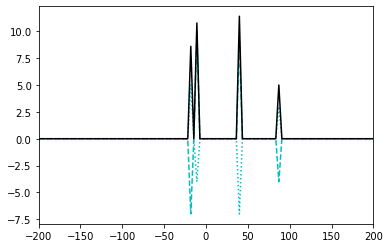

In [5]:
plt.plot(phi, F.real, 'c--', label=r"Real part")
plt.plot(phi, F.imag, 'c:', label=r"Imaginary part")
plt.plot(phi, np.abs(F), 'k-', label=r"Amplitude")
plt.xlim([-200,200])

In [6]:
print(1./K)
dft = DFT1D(W, K, lambda2, lambda2_ref, phi)

0.007936507936507936


In [7]:
P_meas = dft.forward(F)
# Put some noise on the data

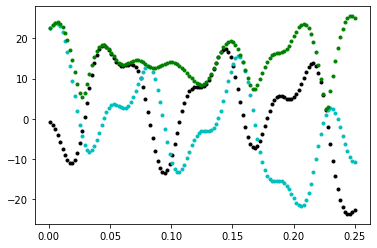

In [8]:
plt.plot(lambda2, P_meas.real, 'k.', label=r"Stokes $Q$")
plt.plot(lambda2, P_meas.imag, 'c.', label=r"Stokes $U$")
plt.plot(lambda2, np.abs(P_meas), 'g.', label=r"$|P|$")

In [20]:
F_dirty = dft.backward(P_meas)
phi_noise_pix_left = np.where(phi<=-500)
phi_noise_pix_right = np.where(phi>=500)
phi_noise_pix = np.hstack([phi_noise_pix_left, phi_noise_pix_right])
noise_F_dirty = (np.std(F_dirty[phi_noise_pix].real) + np.std(F_dirty[phi_noise_pix].imag)) /2
print(noise_F_dirty)

0.0958983451128006


(-200.0, 200.0)

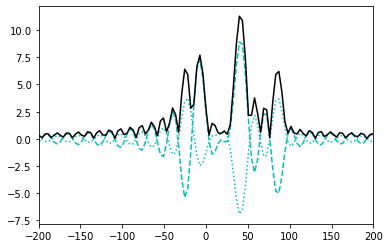

In [10]:
plt.plot(phi, F_dirty.real, 'c--', label=r"Real part")
plt.plot(phi, F_dirty.imag, 'c:', label=r"Imaginary part")
plt.plot(phi, np.abs(F_dirty), 'k-', label=r"Amplitude")
plt.xlim([-200,200])

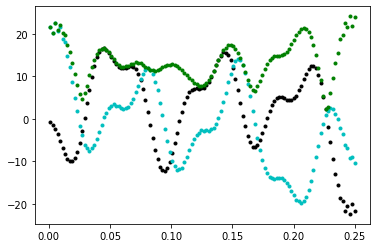

In [11]:
test_P = dft.forward_normalized(F_dirty)
plt.plot(lambda2, test_P.real, 'k.', label=r"Stokes $Q$")
plt.plot(lambda2, test_P.imag, 'c.', label=r"Stokes $U$")
plt.plot(lambda2, np.abs(test_P), 'g.', label=r"$|P|$")

In [12]:
lambda_l1 = 0.1
lambda_tv = 0.0
chi2 = Chi2(b=P_meas, dft_obj=dft, w=W)
tv = TV(reg=lambda_tv)
l1 = L1(reg=lambda_l1)
# F_func = [chi2(P, dft, W), L1(lambda_l1)]
F_func = [chi2, l1]
f_func = [chi2]
g_func = [l1]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

F_real = complex_to_real(F_dirty)

In [13]:
opt = FISTA(F_obj=F_obj, i_guess=F_real, maxiter=2000, verbose=True, fx=chi2, gx=g_obj, noise=1e-5)
#opt = GradientBasedMethod(F_obj=F_obj, i_guess=F_real, maxiter=1000, verbose=True)
obj, X = opt.run()
X = real_to_complex(X)

Iteration:  0  objective function value: 93.58501
Iteration:  50  objective function value: 30.77763
Iteration:  100  objective function value: 27.80499
Iteration:  150  objective function value: 28.25427
Iteration:  200  objective function value: 27.86673
Iteration:  250  objective function value: 27.59219
Iteration:  300  objective function value: 27.40106
Iteration:  350  objective function value: 27.23126
Iteration:  400  objective function value: 27.06126
Iteration:  450  objective function value: 26.88615
Iteration:  500  objective function value: 26.70678
Iteration:  550  objective function value: 26.53295
Iteration:  600  objective function value: 26.36036
Iteration:  650  objective function value: 26.18629
Iteration:  700  objective function value: 26.01032
Iteration:  750  objective function value: 25.83551
Iteration:  800  objective function value: 25.66168
Iteration:  850  objective function value: 25.48810
Iteration:  900  objective function value: 25.31462
Iteration:  950

(-200.0, 200.0)

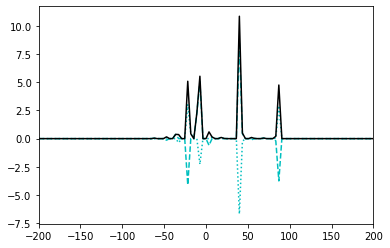

In [14]:
X_recon = X * K / n
plt.plot(phi, X_recon.real, 'c--', label=r"Real part")
plt.plot(phi, X_recon.imag, 'c:', label=r"Imaginary part")
plt.plot(phi, np.abs(X_recon), 'k-', label=r"Amplitude")
plt.xlim([-200,200])

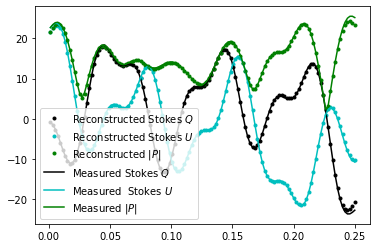

In [15]:
P_final = dft.forward_normalized(X)
plt.plot(lambda2, P_final.real, 'k.', label=r"Reconstructed Stokes $Q$")
plt.plot(lambda2, P_final.imag, 'c.', label=r"Reconstructed Stokes $U$")
plt.plot(lambda2, np.abs(P_final), 'g.', label=r"Reconstructed $|P|$")
plt.plot(lambda2, P_meas.real, 'k-', label=r"Measured Stokes $Q$")
plt.plot(lambda2, P_meas.imag, 'c-', label=r"Measured  Stokes $U$")
plt.plot(lambda2, np.abs(P_meas), 'g-', label=r"Measured $|P|$")
plt.legend()

(-200.0, 200.0)

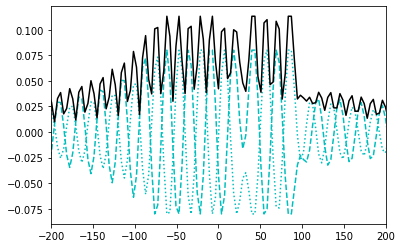

In [21]:
residuals = P_meas - P_final
F_residuals = dft.backward(residuals)

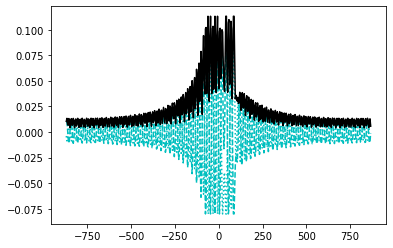

In [22]:
plt.plot(phi, F_residuals.real, 'c--', label=r"Real part")
plt.plot(phi, F_residuals.imag, 'c:', label=r"Imaginary part")
plt.plot(phi, np.abs(F_residuals), 'k-', label=r"Amplitude")